# Reinforcement Learning Project - Navigating a Drone

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [2]:
# Your code here.
class MDPLanding:
    def __init__(self, L, default_reward = -0.01, discount = 0.999):
        self.states = [(x,y,z) for x in range(L) for y in range(L) for z in range(L)]
        self.L = L
        self.terminal_states = {}
        for x in range(L):
            for y in range(L):
                   self.terminal_states[(x,y,0)] = -1
        self.terminal_states[(L / 2, L / 2, 0)] = 1 #drone's goal
        self.default_reward = default_reward
        self.all_actions = []
        self.discount = discount
    
    def actions(self, state):
        moves = []
        if (state[2] == 0):
            moves.append("T")
        else:
            #bounds checking to make sure actions are in the valid state space
            if (state[1] < self.L - 1): moves.append((state[0], state[1] + 1, state[2])) #north
            if (state[1] > 0): moves.append((state[0], state[1] - 1, state[2])) #south
            if (state[0] < self.L - 1): moves.append((state[0] + 1, state[1], state[2])) #east
            if (state[0] > 0): moves.append((state[0] - 1, state[1], state[2])) #west
            if (state[2] < self.L - 1): moves.append((state[0], state[1], state[2] + 1)) #up
            if (state[2] > 0): moves.append((state[0], state[1], state[2] - 1)) #down
        return moves
            
    def reward(self, state):
        if (state[2] == 0):
            return self.terminal_states[state]
        else:
            return self.default_reward
        
    def result(self, state, action):
        if (action == "T"): return state
        elif (action == (state[0], state[1] + 1, state[2]) or action == (state[0], state[1] - 1, state[2]) or action == (state[0] + 1, state[1], state[2]) or action == (state[0] - 1, state[1], state[2]) or action == (state[0], state[1], state[2] + 1) or action == (state[0], state[1], state[2] - 1)): 
            return action
        else: return None

#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [3]:
# Your code here.
import math, random

def policy_evaluation(policies, utils, mdp):
    for state in mdp.states:
        utils[state] = mdp.reward(state) + mdp.discount * utils[mdp.result(state, policies[state])]
    return utils

def policy_iteration(mdp):
    utils = {}
    policies = {}
    for state in mdp.states:
        utils[state] = 0
        policies[state] = mdp.actions(state)[random.randint(0, (len(mdp.actions(state)) - 1))]
        
    stop = False
    while (stop == False):
        stop = True
        utils = policy_evaluation(policies, utils, mdp)
        for state in mdp.states:
            best_util = utils[state]
            best_action = policies[state]
            for action in mdp.actions(state):
                util = mdp.reward(state) + mdp.discount * utils[mdp.result(state, action)]
                if util > best_util:
                    best_util = util
                    best_action = action
            if best_action != policies[state]:
                policies[state] = best_action
                stop = False
        if (stop == True):
            return policies

In [4]:
mdp = MDPLanding(4, -0.01, 0.999)
policies = policy_iteration(mdp)
print("Action: (2,2,1), Policy: " + str(policies[(2,2,1)]))
print("Action: (0,2,1), Policy: " + str(policies[(0,2,1)]))
print("Action: (2,0,1), Policy: " + str(policies[(2,0,1)]))

Action: (2,2,1), Policy: (2, 2, 0)
Action: (0,2,1), Policy: (1, 2, 1)
Action: (2,0,1), Policy: (2, 1, 1)


**Comment:** This looks good and is exactly what we want. Since the goal is (2,2,0), if the action is (2,2,1) it makes sense that it would go directly to our goal by moving down on the **z** axis. If the action is (0,2,1) it makes sense that it will move to (1,2,1) since it wants to eventually get to the (2,2,1) mark so it can land by just decreasing its **z** like in the first action. The third action is also doing the same, starting at (2,0,1) and trying to get to (2,2,1) so it can land, and it makes sense that it increases by 1 in the **y** axis.

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [5]:
#Your code here.
import random

def q_learning(mdp, num_trials):
    q_values = {}
    policies = {}
    total_reward = []
    
    for state in mdp.states:
        q_values[state] = {}
        for action in mdp.actions(state):
            q_values[state][action] = 0
    
    alpha = 0.7
    epsilon = 0.1
    for trial in range(0, num_trials):
        state = mdp.states[random.randint(0, (len(mdp.states) - 1))]
        while state in mdp.terminal_states:
            state = mdp.states[random.randint(0, (len(mdp.states) - 1))]
        
        iterations = 50 #in my video I mention that I set this to num_trials, however this is wrong and I changed it to 50 after re-reading the instructions
        reward = 0
        stop = False
        while (stop == False):
            reward += mdp.reward(state)
            if state in mdp.terminal_states:
                stop = True
            else:
                best_move = None
                best_action = -math.inf
                for action in q_values[state]:
                    if q_values[state][action] > best_action:
                        best_action = q_values[state][action]
                        best_move = action
                        
                new_action = None
                if (random.uniform(0,1) > epsilon):
                    new_action = best_move
                else:
                    new_action = mdp.actions(state)[random.randint(0, (len(mdp.actions(state)) - 1))]
                    
                max_q_value = -math.inf
                for action in q_values[mdp.result(state, new_action)]:
                    if q_values[mdp.result(state, new_action)][action] > max_q_value:
                        max_q_value = q_values[mdp.result(state, new_action)][action]
                        
                q_values[state][new_action] = q_values[state][new_action] + alpha * (mdp.reward(mdp.result(state, new_action)) + mdp.discount * (max_q_value) - q_values[state][new_action])
                state = mdp.result(state, new_action)

                iterations -= 1
                if (iterations <= 0):
                    stop = True  
        total_reward.append(reward)
    return total_reward

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

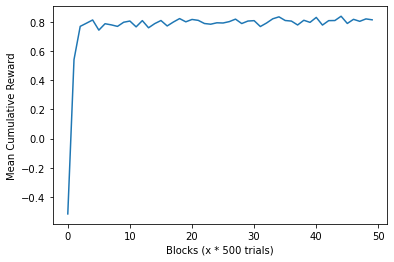

The mean of the last 5000 trials: 0.809912


In [6]:
# Your code here.
import matplotlib

def calculate_mean(lst):
    means = []
    for i in range(0, (int)(len(lst) / 500)): #run through each block
        mean = 0
        for j in range(0, 500): #run through each iteration in a block
            mean += lst[(i * 500) + j]
        means.append(mean / 500) #separate back into blocks
    return means

L = 10
trials = 25000
mdp = MDPLanding(L, -0.01, 0.999)
mean_results = calculate_mean(q_learning(mdp, trials))

plt.plot(mean_results)
plt.xlabel("Blocks (x * 500 trials)")
plt.ylabel("Mean Cumulative Reward")
plt.show()

sum_5000 = 0
for i in range(40, 50):
    sum_5000 += mean_results[i]
mean_5000 = sum_5000 / 10
print("The mean of the last 5000 trials: " + str(mean_5000))

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training? $$\newline$$
**Answer:** The cumulative reward starts off at around -0.5 at the beginning since the Q-learning algorithm doesn't know that much about the environment yet. The algorithm will explore the environment randomly and will randomly choose actions without knowing an optimal path or an easier path to the landing goal. This results in a lower cumulative reward since the agent visits more states that have lower rewards, and as the algorithm runs through trials and learns more about the environment the algorithm gets more confident when calculating Q-values and the reward gets closer to 1.

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8? $$\newline$$
**Answer:** It will be difficult for us to train the drone to reliably obtain rewards greater than 0.8 since the drone will almost always have to cross over states that don't help towards the value of 1 as a reward, and once the drone has found an optimal path it will basically only follow paths that are most similar to the optimal path. The only time that I would see that the drone would be able to get higher rewards than 0.8 would be when it randomly begins right next to the goal but the overall mean would still stay around the optimal path since it's only a random chance that the drone begins near the goal. 

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

Reward Structure 1 - Changing default reward by scale of 10
Policy Learning
Action: (2,2,1), Policy: (2, 2, 0)
Action: (0,2,1), Policy: (1, 2, 1)
Action: (2,0,1), Policy: (2, 1, 1)

Q-Learning


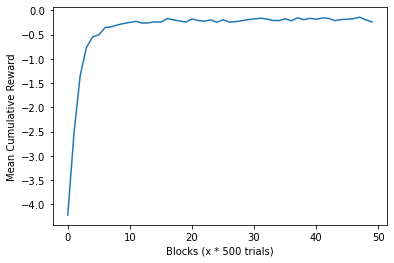

The mean of the last 5000 trials: -0.18514000000000003

Reward Structure 2 - Modifying reward values from -1 and 1
Policy Learning
Action: (2,2,1), Policy: (2, 2, 0)
Action: (0,2,1), Policy: (1, 2, 1)
Action: (2,0,1), Policy: (2, 1, 1)

Q-Learning


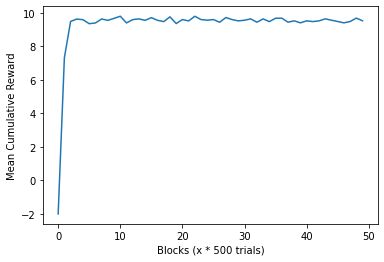

The mean of the last 5000 trials: 9.520364

Reward Structure 3 - Changing reward value based on proximity to goal
Policy Learning
Action: (2,2,1), Policy: (2, 2, 0)
Action: (0,2,1), Policy: (1, 2, 1)
Action: (2,0,1), Policy: (2, 1, 1)

Q-Learning


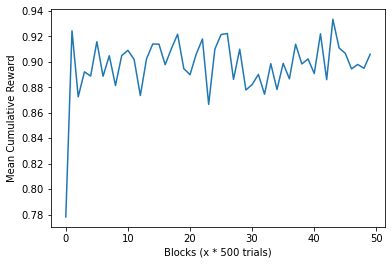

The mean of the last 5000 trials: 0.9044005000000052



In [7]:
print("Reward Structure 1 - Changing default reward by scale of 10")

print("Policy Learning")
mdp = MDPLanding(4, -0.1, 0.5)
policies = policy_iteration(mdp)
print("Action: (2,2,1), Policy: " + str(policies[(2,2,1)]))
print("Action: (0,2,1), Policy: " + str(policies[(0,2,1)]))
print("Action: (2,0,1), Policy: " + str(policies[(2,0,1)]) + "\n")

print("Q-Learning")
L = 10
trials = 25000
mdp = MDPLanding(L, -0.1, 0.5)
mean_results = calculate_mean(q_learning(mdp, trials))

plt.plot(mean_results)
plt.xlabel("Blocks (x * 500 trials)")
plt.ylabel("Mean Cumulative Reward")
plt.show()

sum_5000 = 0
for i in range(40, 50):
    sum_5000 += mean_results[i]
mean_5000 = sum_5000 / 10
print("The mean of the last 5000 trials: " + str(mean_5000) + "\n")

print("Reward Structure 2 - Modifying reward values from -1 and 1")

class MDPLanding_reward2:
    def __init__(self, L, default_reward = -0.01, discount = 0.999):
        self.states = [(x,y,z) for x in range(L) for y in range(L) for z in range(L)]
        self.L = L
        self.terminal_states = {}
        for x in range(L):
            for y in range(L):
                   self.terminal_states[(x,y,0)] = -10
        self.terminal_states[(L / 2,L / 2, 0)] = 10 #drone's goal
        self.default_reward = default_reward
        self.all_actions = []
        self.discount = discount
    
    def actions(self, state):
        moves = []
        if (state[2] == 0):
            moves.append("T")
        else:
            #bounds checking to make sure actions are in the valid state space
            if (state[1] < self.L - 1): moves.append((state[0], state[1] + 1, state[2])) #north
            if (state[1] > 0): moves.append((state[0], state[1] - 1, state[2])) #south
            if (state[0] < self.L - 1): moves.append((state[0] + 1, state[1], state[2])) #east
            if (state[0] > 0): moves.append((state[0] - 1, state[1], state[2])) #west
            if (state[2] < self.L - 1): moves.append((state[0], state[1], state[2] + 1)) #up
            if (state[2] > 0): moves.append((state[0], state[1], state[2] - 1)) #down
        return moves
            
    def reward(self, state):
        if (state[2] == 0):
            return self.terminal_states[state]
        else:
            return self.default_reward
        
    def result(self, state, action):
        if (action == "T"): return state
        elif (action == (state[0], state[1] + 1, state[2]) or action == (state[0], state[1] - 1, state[2]) or action == (state[0] + 1, state[1], state[2]) or action == (state[0] - 1, state[1], state[2]) or action == (state[0], state[1], state[2] + 1) or action == (state[0], state[1], state[2] - 1)): 
            return action
        else: return None
    
print("Policy Learning")
mdp = MDPLanding_reward2(4, -0.01, 0.999)
policies = policy_iteration(mdp)
print("Action: (2,2,1), Policy: " + str(policies[(2,2,1)]))
print("Action: (0,2,1), Policy: " + str(policies[(0,2,1)]))
print("Action: (2,0,1), Policy: " + str(policies[(2,0,1)]) + "\n")

print("Q-Learning")
L = 10
trials = 25000
mdp = MDPLanding_reward2(L, -0.01, 0.999)
mean_results = calculate_mean(q_learning(mdp, trials))

plt.plot(mean_results)
plt.xlabel("Blocks (x * 500 trials)")
plt.ylabel("Mean Cumulative Reward")
plt.show()

sum_5000 = 0
for i in range(40, 50):
    sum_5000 += mean_results[i]
mean_5000 = sum_5000 / 10
print("The mean of the last 5000 trials: " + str(mean_5000) + "\n")

print("Reward Structure 3 - Changing reward value based on proximity to goal")

class MDPLanding_reward3:
    def __init__(self, L, default_reward = -0.01, discount = 0.999):
        self.states = [(x,y,z) for x in range(L) for y in range(L) for z in range(L)]
        self.L = L
        self.terminal_states = {}
        for x in range(L):
            for y in range(L):
                   self.terminal_states[(x,y,0)] = -1
        self.terminal_states[(L / 2,L / 2, 0)] = 1 #drone's goal
        self.default_reward = default_reward
        self.all_actions = []
        self.discount = discount
    
    def actions(self, state):
        moves = []
        if (state[2] == 0):
            moves.append("T")
        else:
            #bounds checking to make sure actions are in the valid state space
            if (state[1] < self.L - 1): moves.append((state[0], state[1] + 1, state[2])) #north
            if (state[1] > 0): moves.append((state[0], state[1] - 1, state[2])) #south
            if (state[0] < self.L - 1): moves.append((state[0] + 1, state[1], state[2])) #east
            if (state[0] > 0): moves.append((state[0] - 1, state[1], state[2])) #west
            if (state[2] < self.L - 1): moves.append((state[0], state[1], state[2] + 1)) #up
            if (state[2] > 0): moves.append((state[0], state[1], state[2] - 1)) #down
        return moves
            
    def reward(self, state):
        if (state[2] == 0):
            return self.terminal_states[state]
        else:
            further_goal = [] #get all states 2 units away from goal
            for x in range((int)(self.L / 2 - 2), (int)(self.L / 2 + 2)):
                for y in range((int)(self.L / 2 - 1), (int)(self.L / 2 + 2)):
                    for z in range(1, L):
                        further_goal.append((x, y, z))
            around_goal = [] #get all states 1 unit away from goal
            for x in range((int)(self.L / 2 - 1), (int)(self.L / 2 + 1)):
                for y in range((int)(self.L / 2 - 1), (int)(self.L / 2 + 1)):
                    for z in range(1, L):
                        around_goal.append((x, y, z))
            if (state == ((int)(self.L / 2), (int)(self.L / 2), 1) or state == ((int)(self.L / 2), (int)(self.L / 2), 2)): #right above the goal
                return -0.01

            if state in further_goal:
                return -0.005
            if state in around_goal:
                return -0.0075           
            return -0.0025
        
    def result(self, state, action):
        if (action == "T"): return state
        elif (action == (state[0], state[1] + 1, state[2]) or action == (state[0], state[1] - 1, state[2]) or action == (state[0] + 1, state[1], state[2]) or action == (state[0] - 1, state[1], state[2]) or action == (state[0], state[1], state[2] + 1) or action == (state[0], state[1], state[2] - 1)): 
            return action
        else: return None
    
print("Policy Learning")
mdp = MDPLanding_reward3(4, -0.01, 0.999)
policies = policy_iteration(mdp)
print("Action: (2,2,1), Policy: " + str(policies[(2,2,1)]))
print("Action: (0,2,1), Policy: " + str(policies[(0,2,1)]))
print("Action: (2,0,1), Policy: " + str(policies[(2,0,1)]) + "\n")

print("Q-Learning")
L = 4
trials = 25000
mdp = MDPLanding_reward3(L, -0.01, 0.999)
mean_results = calculate_mean(q_learning(mdp, trials))

plt.plot(mean_results)
plt.xlabel("Blocks (x * 500 trials)")
plt.ylabel("Mean Cumulative Reward")
plt.show()

sum_5000 = 0
for i in range(40, 50):
    sum_5000 += mean_results[i]
mean_5000 = sum_5000 / 10
print("The mean of the last 5000 trials: " + str(mean_5000) + "\n")

**Explanation:** For my first other reward structure, I was just curious what would happen if I changed the discount and default rewards when initializing the MDP class. I set the discount to 0.5 and the terminal reward to -0.1 (10x factor from previous trials) which resulted in a much lower cumulative reward, with it not even breaking above 0. I noticated that regardless what the discount is, as long as it's less than 1 the mean and policies are the same which makes sense since if the discount is greater than 1 then the drone wouldn't receive any positive rewards for movement through the state space, resulting in an infinite loop since the drone never lands. I noticed that the moves calculated by the policy evaluation are the same, which makes sense since the default reward and discount don't really apply to where the drone goes but instead finding the cumulative reward, so the difference would be in the Q-learning analysis. I feel like the reason the mean is so much lower is because the individual rewards that the algorithm calculates when running through each drone trial is heavily weighted towards a negative value, meaning that if the drone makes a move that isn't optimal then the -0.1 adds up much faster than the -0.01 which results in a lower overall reward even if the drone gets to the final goal. Having the default reward this low can still work on a different scale since the curve of the graph is the same, however on our scale of getting as close to 0.8 as we can it wouldn't work. 

For the second reward structure, I decided to do a pretty simple one where I just modified the rewards that the drone was given in the state space from 1, 0, and -1 to 10, 0, and -10. I assumed that this would work just fine on a larger scale, which it mostly ended up doing just fine however I did notice the means were a little off. Looking at the mean of the last 5000 trials, I noticed that the mean was a 9.65 out of a maximum of 10, which seemed very high (as that would translate to a 0.965 out of 1 for our original trials) which just doesn't seem realistic. Overall I feel like it would still work, as my policy evaluation algorithm still works just fine and finds the same paths and next actions as the original trial that I was happy with, but finding a reward and analyzing the means of the cumulative rewards might need a little work. 

For the third reward structure, I decided to attempt a way that the closer the states get to the goal state the larger the reward got. I started with a general -0.01 which is the default reward for all states that are not within two units of the goal unit, and then increasing the reward unit by unit for the two units closest to the goal. I'm not fully sure if my code is really working or if the rewards are correctly tweaked, since I'm finding that the rewards jump around between 0.8 and 1 however the policy learning system still works the same way and shows a next action that I'm happy with. I would think this would work since it would tell the drone a faster optimal path since it can just see if a reward nearby is higher then it would move to that spot, however it may not work entirely with the reward system since the mean jumps around so much between blocks as shown on the graph.